# Vignetting analysis for EPIC

This analysis follows on a couple of early studies:

* Statistical evaluation of the flux cross-calibration of the XMM-EPIC ([Mateos et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...496..879M/abstract));
* The non-linear X-ray/UV relation in AGNs: contribution of instrumental effects on the X-ray variability ([Elisabeta Lusso, 2018](https://ui.adsabs.harvard.edu/abs/2019AN....340..267L/abstract)).


**NOTES:** 
1. This notebook will read the 3XMM-DR8 catalogue with the added azymuthal angle from my calculations.
2. In this notebook (`work4`) all the analysis is based on sources detected at MOS1 off-axis angles greater than 2 arcmin. In notebook `work3` the analysis is using all off-axis angles, except for the azymuthal dependence.
3. In this notebook (`work5`) I analyse the vignetting correction factors as they are provided in the 3XMM catalogue. 

_21 Aug 2019_

In [1]:
import os

import numpy as np

from astropy.table import Table
import pandas as pd
#import altair as alt

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
#
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')

## Energy bands used in 3XMM

```Basic energy bands: 	
1 	= 	0.2 -   0.5 keV 	 
2 	= 	0.5 -   1.0 keV 	  	 
3 	= 	1.0 -   2.0 keV 	  	 
4 	= 	2.0 -   4.5 keV 	  	 
5 	= 	4.5 - 12.0 keV 	  	 
Broad energy bands: 	
6 	= 	0.2 -   2.0 keV 	  	soft band, no images made, not used
7 	= 	2.0 - 12.0 keV 	  	hard band, no images made, not used
8 	= 	0.2 - 12.0 keV 	  	total band
9 	= 	0.5 -   4.5 keV 	  	XID band
```

In [2]:
#
# define the energy ranges for info
#
full_bands = {1:'[0.2-0.5] keV',2:'[0.5-1.0] keV',3:'[1.0-2.0] keV',4:'[2.0-4.5] keV',5:'[4.5-12.0] keV',\
        8:'[0.2-12.0] keV'}

In [3]:
#
# read the 3XMM-DR8 catalogue
#
wdir = f"{home}/XMM/3XMM"
#t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.0.fits.gz')
#
# my version with the azymuthal angle for the detections
#
t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.1_azymuth.fits.gz')

## Source selection

We apply the following selection of sources from the `3XMM-DR8` catalogue, where `x` is one of `M1, M2` or `PN`:
1. good detection, i.e. `SUM_FLAG == 0`
2. point-like sources, i.e. `EP_EXTENT == 0`
3. at off-axis angles <= 12 arcmin, i.e. `x_OFFAX <= 12` and `M1_OFFAX >= 2.0`
4. flux in [2,12] keV <= 6.0e-12 erg/cm2/s, i.e. `(x_4_FLUX + x_5_FLUX) <= 6.0e-12`, in order to avoid pile-up sources.
5. `CONFUSED == false`
6. `HIGH_BACKGROUND == false`
7. at least 200 source counts in band 8, i.e. `EP_8_CTS >= 200`
8. not too faint sources, i.e. `x_5_FLUX >= 1.0e-15`
9. High SNR in band 5, i.e. `x_5_FLUX/x_5_FLUX_ERR >= 5`

In [4]:
ntot = len(t3)
m1 = t3['SUM_FLAG'] == 0
#
m2 = t3['EP_EXTENT'] == 0
#
m3_m1 = t3['M1_OFFAX'] <= 12.0
m3_m1x = t3['M1_OFFAX'] >= 2.0
#
m3_m2 = t3['M2_OFFAX'] <= 12.0
m3_pn = t3['PN_OFFAX'] <= 12.0
#
m4_m1 = (t3['M1_4_FLUX'] + t3['M1_5_FLUX']) <= 6.0e-12
m4_m2 = (t3['M2_4_FLUX'] + t3['M2_5_FLUX']) <= 6.0e-12
m4_pn = (t3['PN_4_FLUX'] + t3['PN_5_FLUX']) <= 6.0e-12
#
m5 = t3['CONFUSED'] == 0
#
m6 = t3['HIGH_BACKGROUND'] == 0
#
m7 = t3['EP_8_CTS'] >= 200.0
#
m8_m1 = (t3['M1_5_FLUX']) >= 1.0e-15
m8_m2 = (t3['M2_5_FLUX']) >= 1.0e-15
m8_pn = (t3['PN_5_FLUX']) >= 1.0e-15
#
m9_m1 = (t3['M1_5_FLUX']/t3['M1_5_FLUX_ERR']) >= 5.0
m9_m2 = (t3['M2_5_FLUX']/t3['M2_5_FLUX_ERR']) >= 5.0
m9_pn = (t3['PN_5_FLUX']/t3['PN_5_FLUX_ERR']) >= 5.0
#
#xfilter = m1*m2*m3_m1*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7*m8_m1*m8_m2*m8_pn*m9_m1*m9_m2*m9_pn
xfilter = m1*m2*m3_m1*m3_m1x*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7
#
ix = np.where(xfilter)[0]
nx = len(ix)
print (f"Found {nx} out of {ntot} ({100*nx/ntot:.2f} %) 3XMM-DR8 sources with the filtering criteria.")

/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


Found 47457 out of 775153 (6.12 %) 3XMM-DR8 sources with the filtering criteria.


In [5]:
#
# extract the selection as a table
#
tsel = t3[ix]

In [16]:
t = Table.read(f'{wdir}/m1_vig_1000ev_3min.dat',format='ascii.fast_no_header')
# normalise to have max = 0 and convert to percantage
runphi = t['col1']
#vig1_3 = (t['col2'] - np.max(t['col2']))*100.0
vig1_3 = t['col2']
#
t = Table.read(f'{wdir}/m1_vig_10000ev_3min.dat',format='ascii.fast_no_header')
#vig10_3 = (t['col2'] - np.max(t['col2']))*100.0
vig10_3 = t['col2']
#
t = Table.read(f'{wdir}/m1_vig_1000ev_10min.dat',format='ascii.fast_no_header')
#vig1_10 = (t['col2'] - np.max(t['col2']))*100.0
vig1_10 = t['col2']
#
t = Table.read(f'{wdir}/m1_vig_10000ev_10min.dat',format='ascii.fast_no_header')
#vig10_10 = (t['col2'] - np.max(t['col2']))*100.0
vig10_10 = t['col2']


## Plot of MOS1 vignetting per band

Catalogue columns `M1_b_VIG`

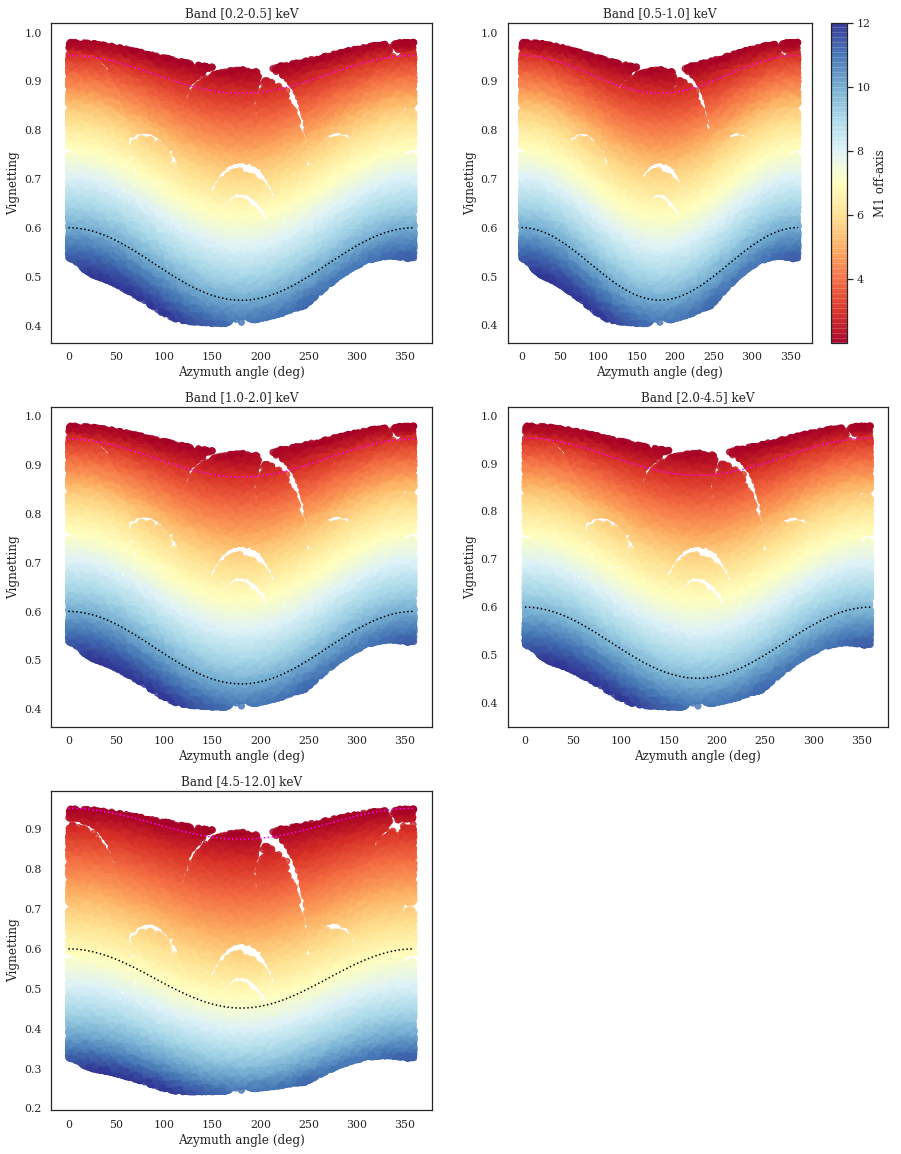

In [20]:
fig = plt.figure(figsize=(15,20))
#ax = fig.add_subplot(1,1,1, projection='polar')
cmx = plt.cm.get_cmap('RdYlBu')

for xband in [1,2,3,4,5]:
    ax = fig.add_subplot(3,2,xband)
    #
    m1_vig = tsel[f'M1_{xband}_VIG']
    m1_az = tsel[f'M1_phi']
    m1_off = tsel[f'M1_OFFAX']
    nqwork = len(qwork)
    #
    p1 = ax.scatter(m1_az,m1_vig,c=m1_off,cmap=cmx,alpha=0.8)
    #
    if (xband == 2):
        cbar = plt.colorbar(p1)
        cbar.set_label('M1 off-axis')
    ax.set_title(f'Band {full_bands[xband]}')
    ax.set_xlabel("Azymuth angle (deg)")
    ax.set_ylabel("Vignetting")
    #
    #
    # the MOS vignetting function from CCF/calview
    #
    ax.plot(runphi,vig1_3,color='magenta',linestyle='dotted',label="1keV, 3'")
    ax.plot(runphi,vig1_10,color='black',linestyle='dotted',label="1keV, 10'")
#plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("MOS1 vignetting")

Text(0.5, 0.98, 'PN vignetting')

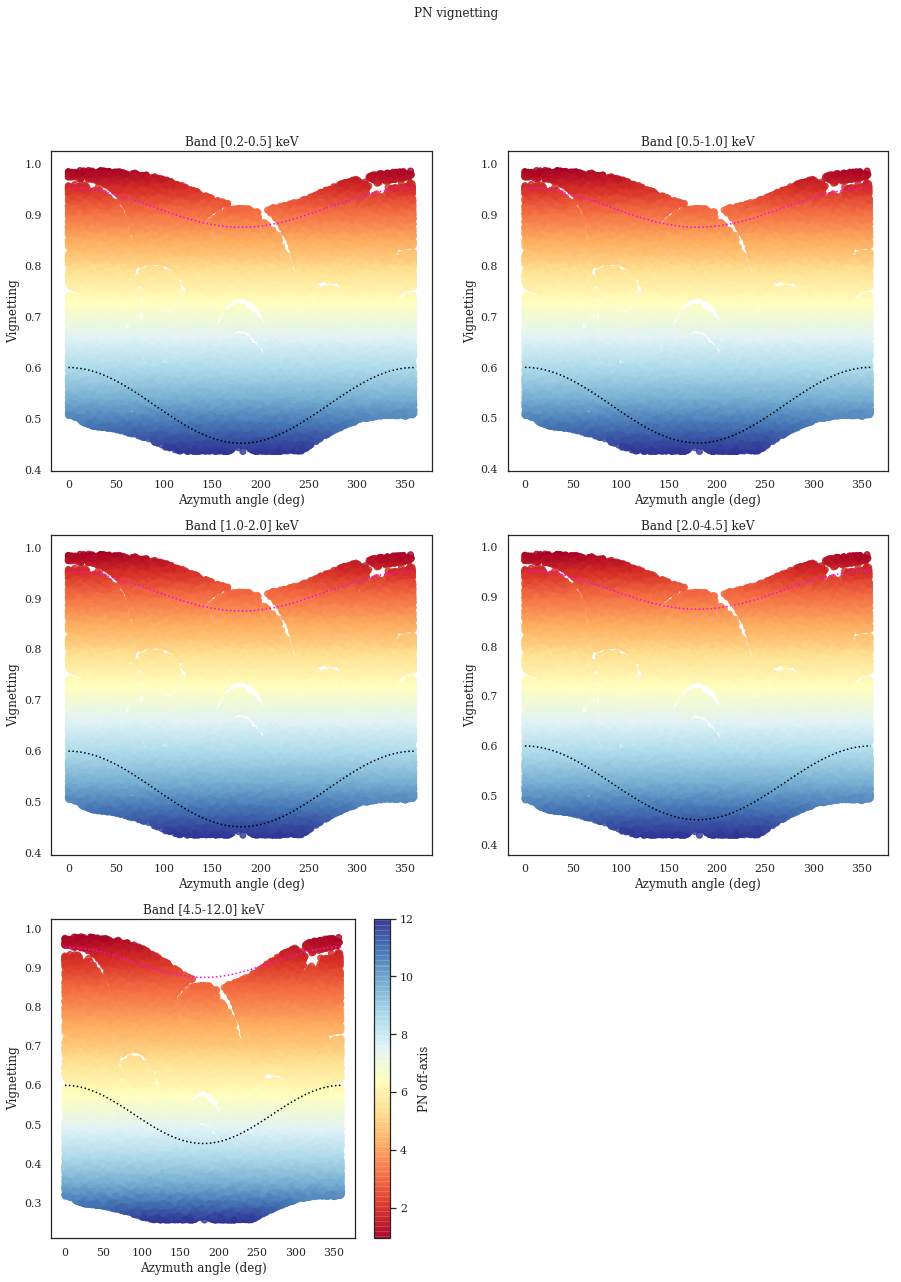

In [23]:
fig = plt.figure(figsize=(15,20))
#ax = fig.add_subplot(1,1,1, projection='polar')
cmx = plt.cm.get_cmap('RdYlBu')

for xband in [1,2,3,4,5]:
    ax = fig.add_subplot(3,2,xband)
    #
    pn_vig = tsel[f'PN_{xband}_VIG']
    pn_az = tsel[f'PN_phi']
    pn_off = tsel[f'PN_OFFAX']
    nqwork = len(qwork)
    #
    p1 = ax.scatter(pn_az,pn_vig,c=pn_off,cmap=cmx,alpha=0.8)
    #
    if (xband == 5):
        cbar = plt.colorbar(p1)
        cbar.set_label('PN off-axis')
    ax.set_title(f'Band {full_bands[xband]}')
    ax.set_xlabel("Azymuth angle (deg)")
    ax.set_ylabel("Vignetting")
    #
    #
    # the MOS vignetting function from CCF/calview
    #
    ax.plot(runphi,vig1_3,color='magenta',linestyle='dotted',label="1keV, 3'")
    ax.plot(runphi,vig1_10,color='black',linestyle='dotted',label="1keV, 10'")
#plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("PN vignetting")